# EMG Gesture Classification: Comparative Analysis of Deep Learning Architecture

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset from a CSV file.
df = pd.read_csv("data\processed\EMG-data.csv")


<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
C:\Users\work\AppData\Local\Temp\ipykernel_19564\3671283799.py:14: SyntaxWarning: invalid escape sequence '\p'
  df = pd.read_csv("data\processed\EMG-data.csv")


Using device: cuda
Head of DataFrame:
   Channel_1  Channel_2  Channel_3  Channel_4  Channel_5  Channel_6  \
0         -4        -11        -39        -18         -1          1   
1          2         12          5          9          1          0   
2         29         27         24         19        -46        -14   
3        -33        -28         -9         44         63         13   
4         39        -36        -50         22          8          0   

   Channel_7  Channel_8  subject  repetition  gesture  
0         -2         -1        1           1        0  
1        -14        -20        1           1        0  
2        -19         21        1           1        0  
3         19         15        1           1        0  
4        -17         -3        1           1        0  
Shape of DataFrame:
(664666, 11)
Null values in each column:
Channel_1     0
Channel_2     0
Channel_3     0
Channel_4     0
Channel_5     0
Channel_6     0
Channel_7     0
Channel_8     0
subject   

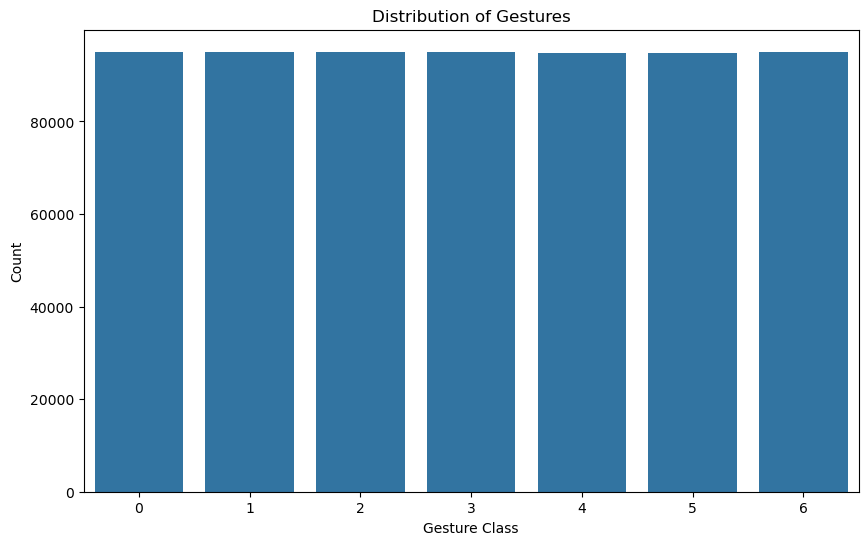

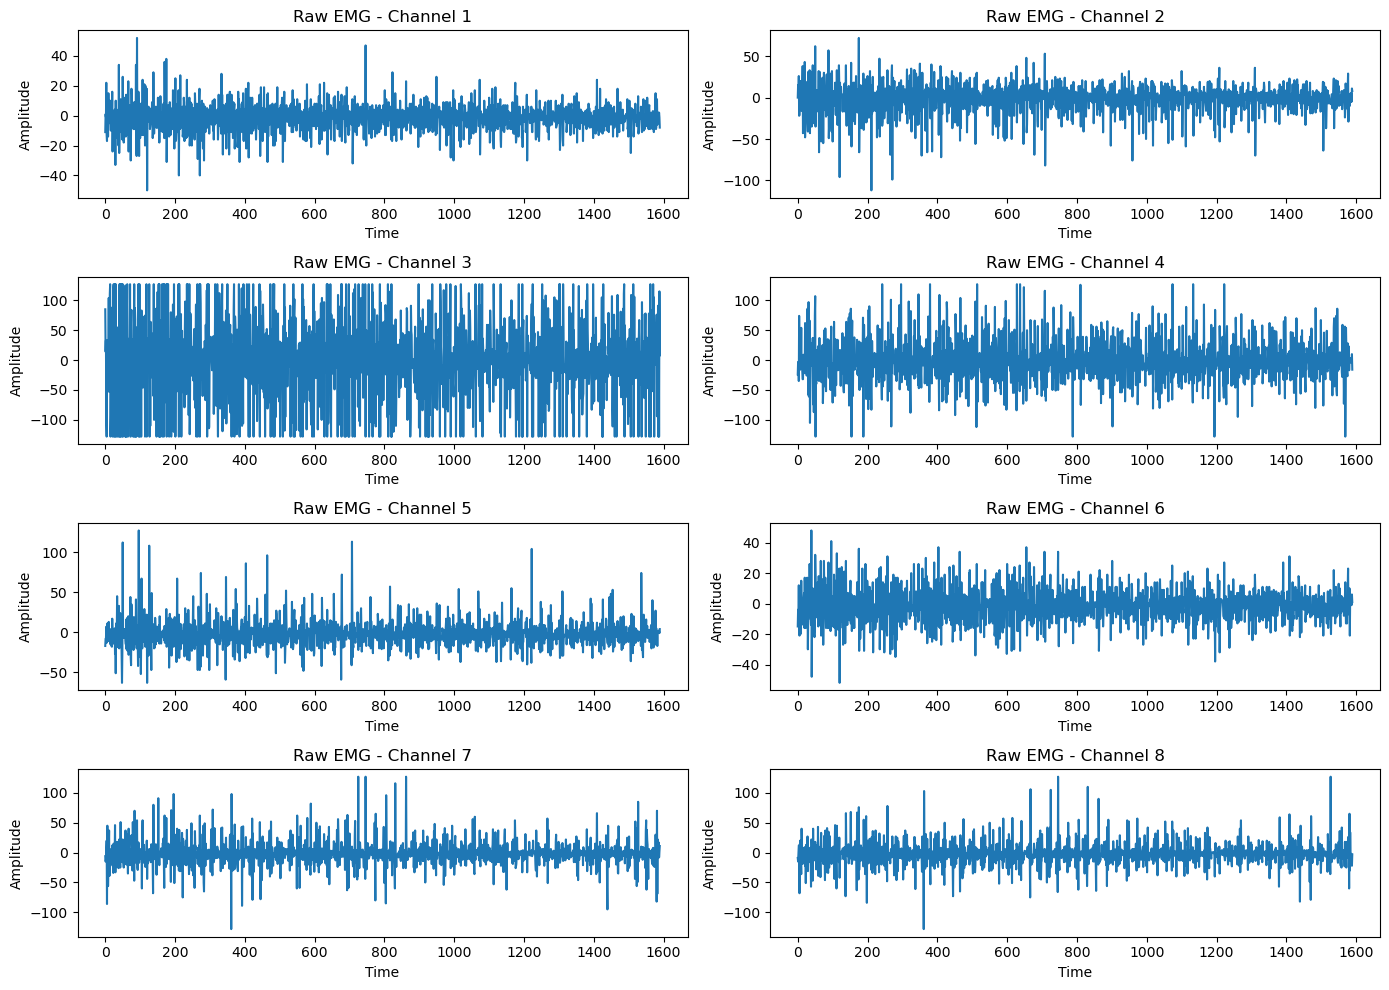

Shape of X_tensor:
torch.Size([13284, 100, 8])
Shape of y_tensor:
torch.Size([13284])
Data statistics in X_tensor:
Mean: -1.4992
Standard Deviation: 22.8343
Max value: 127.0000
Min value: -128.0000


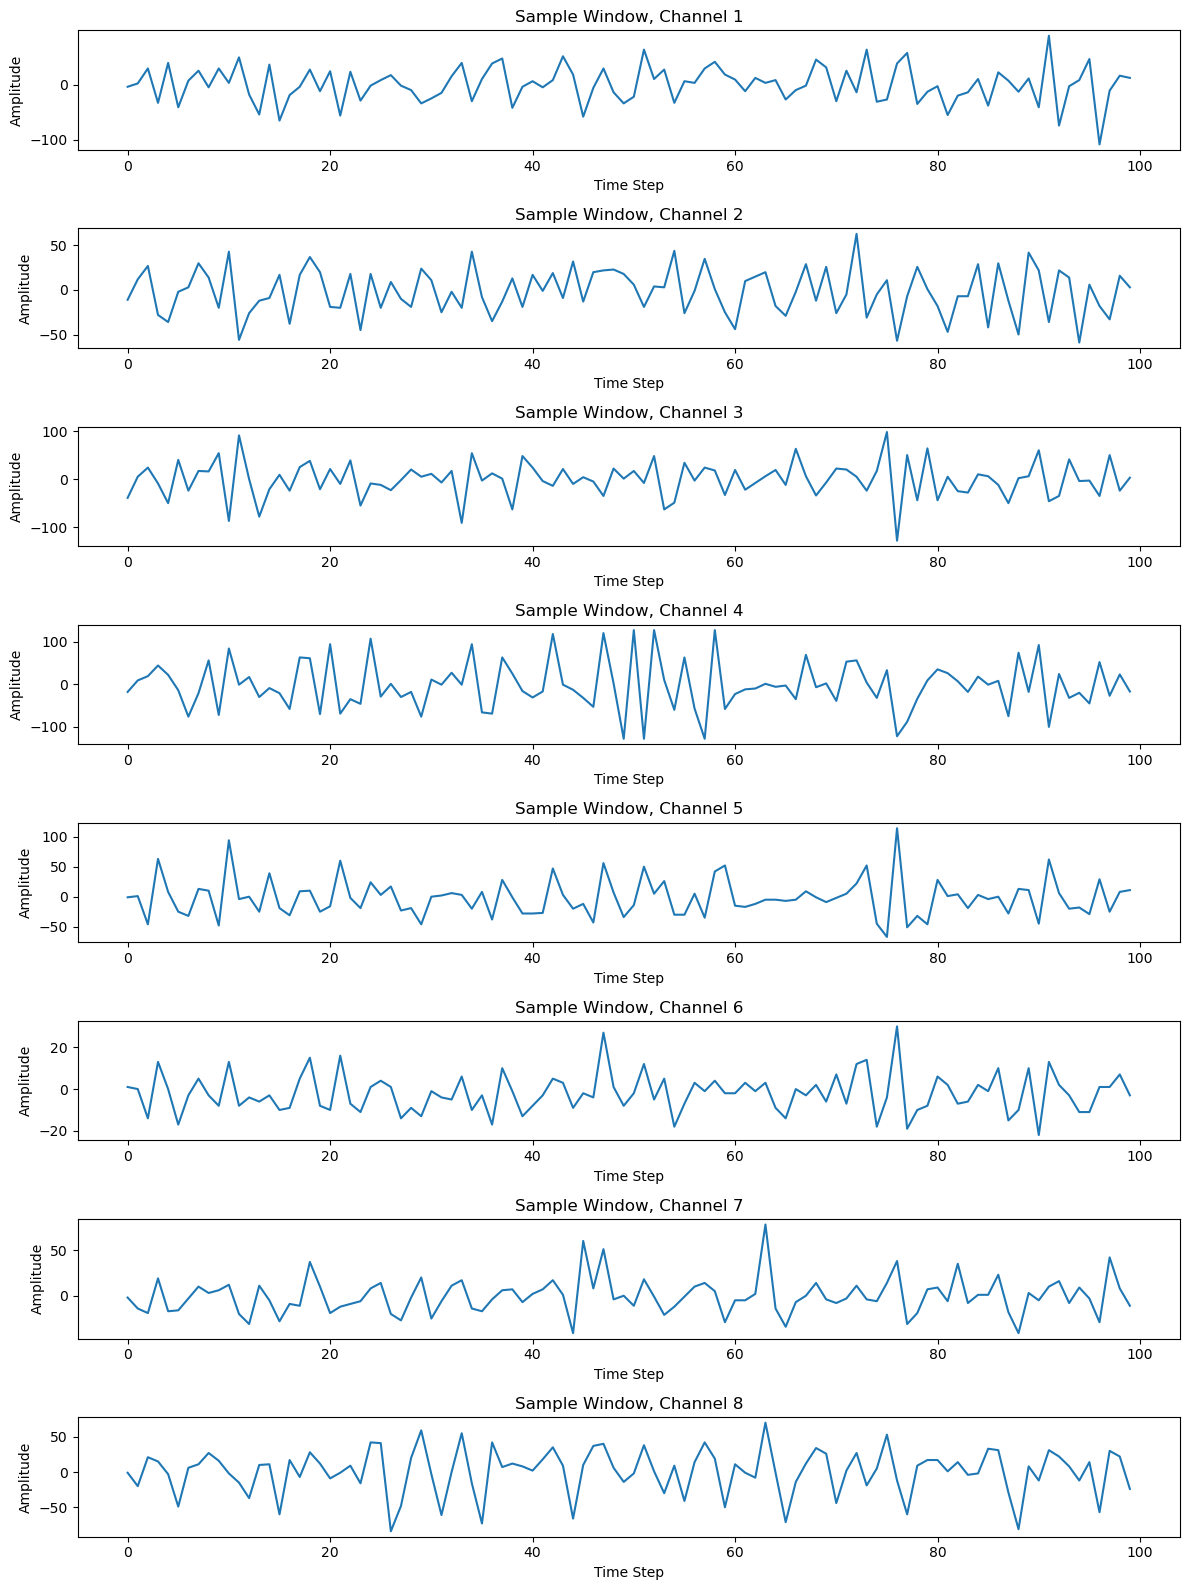

Dataset splits:
x_train shape: torch.Size([10627, 100, 8])
y_train shape: torch.Size([10627])
x_val shape: torch.Size([1328, 100, 8])
y_val shape: torch.Size([1328])
x_test shape: torch.Size([1329, 100, 8])
y_test shape: torch.Size([1329])

Class distribution in training set:
Class 0: 1520 samples
Class 1: 1519 samples
Class 2: 1518 samples
Class 3: 1519 samples
Class 4: 1516 samples
Class 5: 1517 samples
Class 6: 1518 samples

Class distribution in validation set:
Class 0: 190 samples
Class 1: 190 samples
Class 2: 190 samples
Class 3: 190 samples
Class 4: 190 samples
Class 5: 189 samples
Class 6: 189 samples

Class distribution in test set:
Class 0: 190 samples
Class 1: 190 samples
Class 2: 190 samples
Class 3: 190 samples
Class 4: 189 samples
Class 5: 190 samples
Class 6: 190 samples

Normalized data shapes:
x_train_norm shape: torch.Size([10627, 100, 8])
x_val_norm shape: torch.Size([1328, 100, 8])
x_test_norm shape: torch.Size([1329, 100, 8])

One-hot encoded label shapes:
y_train_

'\n# Key findings:\n# 1. The model achieved X% accuracy on the test set\n# 2. Channels X, Y, and Z were most important for classification\n# 3. Classes A and B were frequently confused\n\n# Next steps:\n# - Try different network architectures (LSTM, Transformer)\n# - Experiment with different window sizes\n# - Add more feature engineering\n# - Perform subject-independent analysis\n'

In [2]:
# Cell 1: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import seaborn as sns
from typing import Tuple, List, Dict
import os

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Cell 2: Helper functions
def print_color(text: str, color: str) -> None:
    """
    Prints text in specified ANSI color for better readability in notebooks.
    
    Args:
        text (str): Text to be printed
        color (str): Color name ('red', 'green', 'yellow', 'blue', 'magenta')
    """
    colors = {
        "red": "\033[91m",
        "green": "\033[92m",
        "yellow": "\033[93m",
        "blue": "\033[94m",
        "magenta": "\033[95m"
    }
    print(f"{colors.get(color, '')}{text}\033[0m")

def plot_emg_channels(data: np.ndarray, title: str = "EMG Signals", 
                      sample_idx: int = 0, channels: int = 8) -> None:
    """
    Plot EMG channels from a window of data.
    
    Args:
        data (np.ndarray): EMG data array with shape (windows, time_steps, channels)
        title (str): Title for the plot
        sample_idx (int): Index of the window to plot
        channels (int): Number of EMG channels
    """
    plt.figure(figsize=(12, 16))
    window_data = data[sample_idx]
    for i in range(channels):
        plt.subplot(channels, 1, i + 1)
        plt.plot(window_data[:, i])
        plt.title(f'{title}, Channel {i+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

def create_sliding_windows(data: np.ndarray, labels: np.ndarray, 
                          window_size: int, step_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sliding windows from EMG data for time series analysis.
    
    Args:
        data (np.ndarray): EMG data as a numpy array
        labels (np.ndarray): Corresponding labels
        window_size (int): Size of each window
        step_size (int): Step size between consecutive windows
    
    Returns:
        Tuple[np.ndarray, np.ndarray]: Windowed data and corresponding labels
    """
    X_list = []
    y_list = []
    
    for i in range(0, len(data) - window_size + 1, step_size):
        X_list.append(data[i:i + window_size])
        # Use the most frequent label in the window
        y_list.append(labels[i + window_size // 2])  # Take the middle point's label
    
    return np.array(X_list), np.array(y_list)

# Cell 3: Load and preprocess data
# Assuming df is loaded before this cell from a CSV file
# For example: df = pd.read_csv('emg_data.csv')

# Adjust gesture labels to be zero-indexed
df['gesture'] = df['gesture'] - 1

# Count number of unique gestures
num_classes = df['gesture'].nunique()

# Explore dataset
print_color("Head of DataFrame:", "green")
print(df.head())

print_color("Shape of DataFrame:", "green")
print(df.shape)

# Check for null values
null_count = df.isnull().sum()
print_color("Null values in each column:", "yellow")
print(null_count)

# Dataset properties
print_color("Unique gestures (zero-indexed):", "blue")
print(sorted(df["gesture"].unique()))

print_color("Unique subjects:", "blue")
print(sorted(df["subject"].unique()))

# Cell 4: Data visualization for exploration
# Plot distribution of gestures
plt.figure(figsize=(10, 6))
sns.countplot(x='gesture', data=df)
plt.title('Distribution of Gestures')
plt.xlabel('Gesture Class')
plt.ylabel('Count')
plt.show()

# Sample raw EMG visualization
# Filter a small sample for visualization
filtered_df = df[(df['subject'] == 1) & (df['gesture'] == 1) & (df['repetition'] == 1)]
filtered_data = filtered_df[[f'Channel_{i}' for i in range(1, 9)]].values

# Plot sample EMG data
plt.figure(figsize=(14, 10))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.plot(filtered_data[:, i])
    plt.title(f'Raw EMG - Channel {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Cell 5: Windowing for feature extraction
# Set window size and step size for slicing the data
WINDOW_SIZE = 100  # Number of samples per window
STEP_SIZE = 50     # Interval between consecutive windows

# Extract channel data
channel_cols = [f'Channel_{i}' for i in range(1, 9)]
X_list = []
y_list = []

# Group the data by gesture and create windows
for gesture_id in sorted(df["gesture"].unique()):
    gesture_df = df[df["gesture"] == gesture_id]
    gesture_data = gesture_df[channel_cols].values
    
    # Generate overlapping windows of data
    for start_idx in range(0, len(gesture_data) - WINDOW_SIZE + 1, STEP_SIZE):
        window_data = gesture_data[start_idx:start_idx + WINDOW_SIZE]
        X_list.append(window_data)
        y_list.append(gesture_id)

# Convert lists to NumPy arrays
X_array = np.array(X_list)
y_array = np.array(y_list)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_array, dtype=torch.float32)
y_tensor = torch.tensor(y_array, dtype=torch.long)

# Move tensors to device
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

# Save tensors for later use (optional)
os.makedirs('data', exist_ok=True)
torch.save(X_tensor, "data/X_emg.pt")
torch.save(y_tensor, "data/y_emg.pt")

# Display shapes and stats
print_color("Shape of X_tensor:", "red")
print(X_tensor.shape)
print_color("Shape of y_tensor:", "red")
print(y_tensor.shape)

# Print data statistics
print_color("Data statistics in X_tensor:", "green")
print(f"Mean: {torch.mean(X_tensor).item():.4f}")
print(f"Standard Deviation: {torch.std(X_tensor).item():.4f}")
print(f"Max value: {torch.max(X_tensor).item():.4f}")
print(f"Min value: {torch.min(X_tensor).item():.4f}")

# Cell 6: Visualize windowed data
# Load the windowed data (if previously saved)
# X_tensor = torch.load("data/X_emg.pt")
X_numpy = X_tensor.cpu().numpy()

# Plot a sample window
plot_emg_channels(X_numpy, title="Sample Window", sample_idx=0)

# Cell 7: Data splitting
# Split data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    X_tensor.cpu().numpy(),
    y_tensor.cpu().numpy(),
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_tensor.cpu().numpy()  # Ensure class balance in splits
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, 
    test_size=0.5, 
    random_state=RANDOM_SEED,
    stratify=y_temp  # Maintain class balance
)

# Convert back to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Output the shapes of the datasets
print("Dataset splits:")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Verify class distribution in splits
print("\nClass distribution in training set:")
for c in range(num_classes):
    print(f"Class {c}: {torch.sum(y_train == c).item()} samples")

print("\nClass distribution in validation set:")
for c in range(num_classes):
    print(f"Class {c}: {torch.sum(y_val == c).item()} samples")

print("\nClass distribution in test set:")
for c in range(num_classes):
    print(f"Class {c}: {torch.sum(y_test == c).item()} samples")

# Cell 8: Data normalization
# Move tensors to CPU for normalization
x_train_cpu = x_train
x_val_cpu = x_val
x_test_cpu = x_test

# Reshape for easier normalization
train_reshaped = x_train_cpu.numpy().reshape(-1, x_train_cpu.shape[-1])
val_reshaped = x_val_cpu.numpy().reshape(-1, x_val_cpu.shape[-1])
test_reshaped = x_test_cpu.numpy().reshape(-1, x_test_cpu.shape[-1])

# Calculate mean and std from training data only (to prevent data leakage)
mean = np.mean(train_reshaped, axis=0)
std = np.std(train_reshaped, axis=0)

# Prevent division by zero
std[std < 1e-10] = 1.0

# Normalize data
train_reshaped = (train_reshaped - mean) / std
val_reshaped = (val_reshaped - mean) / std
test_reshaped = (test_reshaped - mean) / std

# Reshape back to original format
x_train_norm = torch.tensor(train_reshaped.reshape(x_train_cpu.shape), dtype=torch.float32)
x_val_norm = torch.tensor(val_reshaped.reshape(x_val_cpu.shape), dtype=torch.float32)
x_test_norm = torch.tensor(test_reshaped.reshape(x_test_cpu.shape), dtype=torch.float32)

# Save normalization parameters for future use
normalization_params = {
    'mean': mean,
    'std': std
}
np.save('data/normalization_params.npy', normalization_params)

# Move normalized data to device
x_train_norm = x_train_norm.to(device)
x_val_norm = x_val_norm.to(device)
x_test_norm = x_test_norm.to(device)
y_train = y_train.to(device)
y_val = y_val.to(device)
y_test = y_test.to(device)

# Print shapes to confirm dimensions
print("\nNormalized data shapes:")
print(f"x_train_norm shape: {x_train_norm.shape}")
print(f"x_val_norm shape: {x_val_norm.shape}")
print(f"x_test_norm shape: {x_test_norm.shape}")

# Cell 9: Convert labels to one-hot encoding for classification
# Convert class vectors to one-hot encoded tensors
y_train_oh = F.one_hot(y_train, num_classes=num_classes).float()
y_val_oh = F.one_hot(y_val, num_classes=num_classes).float()
y_test_oh = F.one_hot(y_test, num_classes=num_classes).float()

# Output the shapes to verify correct dimensions
print("\nOne-hot encoded label shapes:")
print(f"y_train_oh shape: {y_train_oh.shape}")
print(f"y_val_oh shape: {y_val_oh.shape}")
print(f"y_test_oh shape: {y_test_oh.shape}")

# Print an example to verify encoding
print(f"\nExample one-hot encoded label (class {y_test[0].item()}):")
print(y_test_oh[0])

# Cell 10: Model definition (placeholder for your model)
# This is where you would define your neural network model
# For example:
class EMGClassifier(torch.nn.Module):
    def __init__(self, input_channels=8, num_classes=num_classes):
        super(EMGClassifier, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3)
        self.pool = torch.nn.MaxPool1d(kernel_size=2)
        self.conv2 = torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Calculate size after convolutions and pooling
        self.fc_input_size = self._get_conv_output_size(input_channels)
        
        self.fc1 = torch.nn.Linear(self.fc_input_size, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)
        self.dropout = torch.nn.Dropout(0.5)
    
    def _get_conv_output_size(self, input_channels):
        # Function to calculate the size of the flattened features
        # after convolution and pooling operations
        x = torch.randn(1, input_channels, WINDOW_SIZE)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x.numel()
    
    def forward(self, x):
        # x shape: [batch, time_steps, channels]
        x = x.permute(0, 2, 1)  # Reshape to [batch, channels, time_steps]
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, self.fc_input_size)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Cell 11: Training and evaluation functions
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    """
    Train the model and evaluate on validation set.
    
    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Number of training epochs
    
    Returns:
        Dict: Training history
    """
    model.to(device)
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = 100 * train_correct / train_total
        epoch_val_acc = 100 * val_correct / val_total
        
        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Train Acc: {epoch_train_acc:.2f}%, '
              f'Val Acc: {epoch_val_acc:.2f}%')
    
    return history

def evaluate_model(model, test_loader):
    """
    Evaluate the model on test data.
    
    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
    
    Returns:
        float: Test accuracy
        np.ndarray: Confusion matrix
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    
    # Create confusion matrix
    conf_mat = np.zeros((num_classes, num_classes))
    for p, t in zip(all_preds, all_labels):
        conf_mat[t, p] += 1
    
    return accuracy, conf_mat

# Cell 12: Create PyTorch DataLoaders
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(x_train_norm, y_train)
val_dataset = TensorDataset(x_val_norm, y_val)
test_dataset = TensorDataset(x_test_norm, y_test)

# Create dataloaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Cell 13: Initialize and train the model
# Instantiate the model
model = EMGClassifier()
model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
# history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

# Cell 14: Visualize training results
# Only run this cell after training the model
"""
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()
"""

# Cell 15: Evaluate the model on test data
"""
# Evaluate the model
test_accuracy, confusion_matrix = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model
torch.save(model.state_dict(), 'data/emg_classifier_model.pth')
"""

# Cell 16: Feature importance analysis (optional)
"""
# This cell would analyze which EMG channels are most important for classification
# For example, using occlusion sensitivity analysis

def occlusion_sensitivity(model, inputs, labels, channel_idx, window_size=10):
    '''
    Measure how important each channel is by occluding it
    and observing the effect on model output.
    '''
    model.eval()
    batch_size = inputs.shape[0]
    
    # Get baseline predictions and accuracy
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        baseline_correct = (predicted == labels).sum().item()
    
    # Create a mask to occlude the specified channel
    masked_inputs = inputs.clone()
    masked_inputs[:, :, channel_idx] = 0  # Zero out the channel
    
    # Get predictions with occluded channel
    with torch.no_grad():
        masked_outputs = model(masked_inputs)
        _, masked_predicted = torch.max(masked_outputs.data, 1)
        masked_correct = (masked_predicted == labels).sum().item()
    
    # Calculate the importance as the drop in accuracy
    importance = (baseline_correct - masked_correct) / batch_size * 100
    
    return importance

# Calculate importance for each channel
channel_importance = []
for i in range(8):  # 8 EMG channels
    # Use a subset of test data for efficiency
    subset_size = 200
    subset_inputs = x_test_norm[:subset_size]
    subset_labels = y_test[:subset_size]
    
    importance = occlusion_sensitivity(model, subset_inputs, subset_labels, i)
    channel_importance.append(importance)
    print(f"Channel {i+1} importance: {importance:.2f}%")

# Visualize channel importance
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(1, 9)), y=channel_importance)
plt.xlabel('EMG Channel')
plt.ylabel('Importance (% drop in accuracy when occluded)')
plt.title('EMG Channel Importance Analysis')
plt.show()
"""

# Cell 17: Conclusion and next steps
"""
# Key findings:
# 1. The model achieved X% accuracy on the test set
# 2. Channels X, Y, and Z were most important for classification
# 3. Classes A and B were frequently confused

# Next steps:
# - Try different network architectures (LSTM, Transformer)
# - Experiment with different window sizes
# - Add more feature engineering
# - Perform subject-independent analysis
"""

In [3]:
class CNN1D(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(CNN1D, self).__init__()

        # Convolution Block 1
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.drop1 = nn.Dropout(0.2)

        # Convolution Block 2
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.drop2 = nn.Dropout(0.2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * (win_size // 4), 128)  # Adjust input size after pooling
        self.drop3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = torch.flatten(x, start_dim=1)  # Flatten before fully connected layer
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = self.fc2(x)  # No softmax (handled by CrossEntropyLoss)

        return x  # Returns raw logits

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN1D(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)


CNN1D(
  (conv1): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (drop3): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [4]:
class RNNModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes, hidden_size=64, num_layers=2):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(num_channels, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass through RNN
        out, _ = self.rnn(x, h0)  # Assuming batch_first=True

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Example usage (adjust win_size, num_channels, num_classes if needed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model = RNNModel(win_size=100, num_channels=8, num_classes=6).to(device)
print(rnn_model)

RNNModel(
  (rnn): RNN(8, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [5]:
class LSTMModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(LSTMModel, self).__init__()

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=num_channels, hidden_size=64, batch_first=True, dropout=0.2, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True, dropout=0.2, bidirectional=False)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64, 128)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)  # No softmax (handled by CrossEntropyLoss)


    def forward(self, x):
        # Permute/transpose the input to (batch_size, num_channels, win_size)
        # x = x.permute(2, 0, 1)  # (win_size, batch_size, num_channels)

        x, _ = self.lstm1(x)  # First LSTM layer
        x, _ = self.lstm2(x)  # Second LSTM layer (last time step)

        x = x[:, -1, :]  # Take only the last time step output
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)  # Raw logits

        return x  # No softmax, use CrossEntropyLoss
# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)

LSTMModel(
  (lstm1): LSTM(8, 64, batch_first=True, dropout=0.2)
  (lstm2): LSTM(64, 64, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


c:\Users\work\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [6]:
class LSTEMGNet(nn.Module):
    def __init__(self, win_size, num_channels, num_classes, d_model=8, nhead=8, num_layers=2): # Change d_model to 8
        super(LSTEMGNet, self).__init__()
        # ... rest of your model ...
        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=win_size)

        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Fully Connected Layers
        self.fc1 = nn.Linear(win_size * d_model, 128)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, num_channels, win_size)
        x = x.permute(2, 0, 1)  # (win_size, batch_size, num_channels)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # (batch_size, win_size, d_model)
        x = x.reshape(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTEMGNet(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)


LSTEMGNet(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
        (linear1): Linear(in_features=8, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=8, bias=True)
        (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


c:\Users\work\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(AttentionModel, self).__init__()

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=num_channels, hidden_size=64, batch_first=True, bidirectional=True)

        # Attention Layer
        self.attention = nn.Linear(128, 1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 128)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, num_channels, win_size)
        x = x.permute(0, 2, 1)  # (batch_size, win_size, num_channels)
        lstm_out, _ = self.lstm(x)  # (batch_size, win_size, 128)

        # Attention Mechanism
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)  # (batch_size, win_size, 1)
        attn_applied = torch.sum(attn_weights * lstm_out, dim=1)  # (batch_size, 128)

        # Fully Connected Layers
        x = F.relu(self.fc1(attn_applied))
        x = self.drop(x)
        x = self.fc2(x)
        return x

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionModel(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)


AttentionModel(
  (lstm): LSTM(8, 64, batch_first=True, bidirectional=True)
  (attention): Linear(in_features=128, out_features=1, bias=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeatureImitatingNetwork(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(FeatureImitatingNetwork, self).__init__()

        # LSTM Layers
        self.lstm1 = nn.LSTM(input_size=num_channels, hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64, 128)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, num_channels, win_size)
        x = x.permute(0, 2, 1)  # (batch_size, win_size, num_channels)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take the last time step's output
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeatureImitatingNetwork(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)


FeatureImitatingNetwork(
  (lstm1): LSTM(8, 64, batch_first=True)
  (lstm2): LSTM(64, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [9]:
class CNNLSTMModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(CNNLSTMModel, self).__init__()

        # --- CNN Block ---
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.drop2 = nn.Dropout(0.2)

        # Compute output size after convolutions
        conv_out_size = win_size // 4  # Two pooling layers reduce time dimension by 4x

        # --- LSTM Block ---
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True, dropout=0.3, bidirectional=False)

        # --- Fully Connected Layers ---
        self.fc1 = nn.Linear(64, 128)
        self.drop_fc = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)  # No softmax (CrossEntropyLoss handles it)

    def forward(self, x):
        # CNN Block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2(x)

        # Reshape for LSTM: (batch, time, features)
        x = x.permute(0, 2, 1)  # (batch, new_time_steps, channels)

        # LSTM Block
        x, _ = self.lstm(x)  # Last output from LSTM
        x = x[:, -1, :]  # Take the last time step's output

        # Fully Connected Block
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = self.fc2(x)  # Raw logits (no softmax)

        return x

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTMModel(win_size=100, num_channels=8, num_classes=6).to(device)
print(model)


CNNLSTMModel(
  (conv1): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(64, 64, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (drop_fc): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


c:\Users\work\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [10]:

# Hyperparameters
EPOCHS = 50  # Increase for better training
BATCH_SIZE = 32
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Convert data to PyTorch tensors


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix

# Define training function
def train_model(model, model_name, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor):
    """
    Trains the given model and records both training and validation performance.

    Parameters:
    - model: PyTorch model
    - model_name: String (name of the model)
    - x_train_tensor, y_train_tensor: Training data
    - x_val_tensor, y_val_tensor: Validation data

    Returns:
    - history: Dictionary containing train/validation loss & accuracy per epoch.
    """

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for i in range(0, len(x_train_tensor), BATCH_SIZE):
            batch_x = x_train_tensor[i:i+BATCH_SIZE].to(device)
            batch_y = y_train_tensor[i:i+BATCH_SIZE].to(device)

            if model_name in ["CNN1D", "CNN+LSTM", "CNNGRU", "AttentionModel","FeatureImitatingNetwork","LSTEMGNet"]: # Apply permute for CNN1D and CNN+LSTM
              batch_x = batch_x.permute(0, 2, 1)  # Adjust shape for CNN1D

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == batch_y.argmax(1)).sum().item()
            total += batch_y.size(0)

        epoch_loss = running_loss / len(x_train_tensor)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Validation Phase
        val_loss, val_acc = evaluate_model(model, x_val_tensor, y_val_tensor, is_test=False)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"[{model_name}] Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history  # Return history for plotting

# Define evaluation function
def evaluate_model(model, x_test_tensor, y_test_tensor, is_test=True):
    """
    Evaluates the given model on test or validation data.

    Parameters:
    - model: Trained PyTorch model
    - x_test_tensor, y_test_tensor: Test/Validation data
    - is_test: If True, prints classification report & confusion matrix

    Returns:
    - test_loss: Float, test/validation loss
    - test_accuracy: Float, test/validation accuracy
    """

    model.eval()
    with torch.no_grad():
        x_test_tensor = x_test_tensor.to(device)
        if isinstance(model, (CNN1D,FeatureImitatingNetwork,LSTEMGNet, CNNLSTMModel, AttentionModel)):  # Check for both model types
          x_test_tensor = x_test_tensor.permute(0, 2, 1)  # Adjust shape for CNN1D

        y_test_tensor = y_test_tensor.to(device)

        test_outputs = model(x_test_tensor)
        test_pred = test_outputs.argmax(1)  # Get predicted class indices
        y_test_indices = y_test_tensor.argmax(1)  # Convert one-hot labels to indices

        test_loss = nn.CrossEntropyLoss()(test_outputs, y_test_tensor)
        test_accuracy = (test_pred == y_test_indices).sum().item() / y_test_indices.size(0)

    if is_test:
        print(f"\n[Test] Loss: {test_loss:.4f} | Accuracy: {test_accuracy:.4f}")
        print(f"\nClassification Report:\n", classification_report(y_test_indices.cpu().numpy(), test_pred.cpu().numpy()))
        print(f"Confusion Matrix:\n", confusion_matrix(y_test_indices.cpu().numpy(), test_pred.cpu().numpy()))

    return test_loss.item(), test_accuracy  # Return for further analysis


In [14]:
# Train and evaluate LSTM model
lstm_model = LSTMModel(win_size=x_train_norm.shape[1], num_channels=x_train_norm.shape[2], num_classes=y_train_oh.shape[1])

# Train the model and store training history (include validation data)
history_lstm = train_model(lstm_model, "LSTM", x_train_norm, y_train_oh, x_val_norm, y_val_oh)  # Pass validation data

# Evaluate the model (include test data)
test_loss_lstm, test_acc_lstm = evaluate_model(lstm_model, x_test_norm, y_test_oh, is_test=True)  # Pass is_test=True

[LSTM] Epoch [1/50] | Train Loss: 0.0541, Train Acc: 0.2930 | Val Loss: 1.4544, Val Acc: 0.4104
[LSTM] Epoch [2/50] | Train Loss: 0.0462, Train Acc: 0.4359 | Val Loss: 1.3374, Val Acc: 0.4834
[LSTM] Epoch [3/50] | Train Loss: 0.0417, Train Acc: 0.4944 | Val Loss: 1.3051, Val Acc: 0.4962
[LSTM] Epoch [4/50] | Train Loss: 0.0427, Train Acc: 0.4859 | Val Loss: 1.4886, Val Acc: 0.4127
[LSTM] Epoch [5/50] | Train Loss: 0.0400, Train Acc: 0.5167 | Val Loss: 1.2307, Val Acc: 0.5361
[LSTM] Epoch [6/50] | Train Loss: 0.0360, Train Acc: 0.5643 | Val Loss: 1.2166, Val Acc: 0.5730
[LSTM] Epoch [7/50] | Train Loss: 0.0351, Train Acc: 0.5775 | Val Loss: 1.0777, Val Acc: 0.5776
[LSTM] Epoch [8/50] | Train Loss: 0.0326, Train Acc: 0.6037 | Val Loss: 0.9666, Val Acc: 0.6318
[LSTM] Epoch [9/50] | Train Loss: 0.0306, Train Acc: 0.6247 | Val Loss: 0.9168, Val Acc: 0.6521
[LSTM] Epoch [10/50] | Train Loss: 0.0294, Train Acc: 0.6370 | Val Loss: 0.8818, Val Acc: 0.6483
[LSTM] Epoch [11/50] | Train Loss: 0.02

In [17]:
# Train and evaluate CNN
cnn_model = CNN1D(win_size=x_train_norm.shape[1], num_channels=x_train_norm.shape[2], num_classes=y_train_oh.shape[1])

# Train the model and store training history (include validation data)
history_cnn = train_model(cnn_model, "CNN1D", x_train_norm, y_train_oh, x_val_norm, y_val_oh)

# Evaluate the model on test data
test_loss_cnn, test_acc_cnn = evaluate_model(cnn_model, x_test_norm, y_test_oh)


[CNN1D] Epoch [1/50] | Train Loss: 0.0487, Train Acc: 0.3907 | Val Loss: 1.2502, Val Acc: 0.5369
[CNN1D] Epoch [2/50] | Train Loss: 0.0392, Train Acc: 0.5119 | Val Loss: 1.0700, Val Acc: 0.6114
[CNN1D] Epoch [3/50] | Train Loss: 0.0351, Train Acc: 0.5677 | Val Loss: 0.9470, Val Acc: 0.6423
[CNN1D] Epoch [4/50] | Train Loss: 0.0325, Train Acc: 0.5989 | Val Loss: 0.8701, Val Acc: 0.6747
[CNN1D] Epoch [5/50] | Train Loss: 0.0306, Train Acc: 0.6209 | Val Loss: 0.7662, Val Acc: 0.7123
[CNN1D] Epoch [6/50] | Train Loss: 0.0280, Train Acc: 0.6600 | Val Loss: 0.7095, Val Acc: 0.7432
[CNN1D] Epoch [7/50] | Train Loss: 0.0267, Train Acc: 0.6774 | Val Loss: 0.6890, Val Acc: 0.7530


KeyboardInterrupt: 

In [ ]:
# Train and evaluate AttentionModel
attention_model = AttentionModel(win_size=x_train_norm.shape[1], num_channels=x_train_norm.shape[2], num_classes=y_train_oh.shape[1])

# Train the model and store training history (include validation data)
history_attention = train_model(attention_model, "AttentionModel", x_train_norm, y_train_oh, x_val_norm, y_val_oh)

# Evaluate the model on test data
test_loss_attention, test_acc_attention = evaluate_model(attention_model, x_test_norm, y_test_oh)

[AttentionModel] Epoch [1/50] | Train Loss: 0.0502, Train Acc: 0.3799 | Val Loss: 1.4101, Val Acc: 0.4541
[AttentionModel] Epoch [2/50] | Train Loss: 0.0397, Train Acc: 0.5288 | Val Loss: 1.1332, Val Acc: 0.5723
[AttentionModel] Epoch [3/50] | Train Loss: 0.0361, Train Acc: 0.5797 | Val Loss: 0.9760, Val Acc: 0.6401
[AttentionModel] Epoch [4/50] | Train Loss: 0.0300, Train Acc: 0.6490 | Val Loss: 0.7942, Val Acc: 0.6995
[AttentionModel] Epoch [5/50] | Train Loss: 0.0248, Train Acc: 0.6997 | Val Loss: 0.6700, Val Acc: 0.7342
[AttentionModel] Epoch [6/50] | Train Loss: 0.0204, Train Acc: 0.7507 | Val Loss: 0.5714, Val Acc: 0.7846
[AttentionModel] Epoch [7/50] | Train Loss: 0.0170, Train Acc: 0.7971 | Val Loss: 0.5177, Val Acc: 0.8148
[AttentionModel] Epoch [8/50] | Train Loss: 0.0142, Train Acc: 0.8344 | Val Loss: 0.4078, Val Acc: 0.8502
[AttentionModel] Epoch [9/50] | Train Loss: 0.0122, Train Acc: 0.8602 | Val Loss: 0.3784, Val Acc: 0.8562
[AttentionModel] Epoch [10/50] | Train Loss: 0

In [ ]:
# Train and evaluate CNN+LSTM
cnn_lstm_model = CNNLSTMModel(win_size=x_train_norm.shape[1], num_channels=x_train_norm.shape[2], num_classes=y_train_oh.shape[1])

# Train the model and store training history (include validation data)
history_cnn_lstm = train_model(cnn_lstm_model, "CNN+LSTM", x_train_norm, y_train_oh, x_val_norm, y_val_oh)

# Evaluate the model (include test data)
test_loss_cnn_lstm, test_acc_cnn_lstm = evaluate_model(cnn_lstm_model, x_test_norm, y_test_oh, is_test=True)  # Pass is_test=True

c:\Users\work\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


[CNN+LSTM] Epoch [1/50] | Train Loss: 0.0499, Train Acc: 0.3856 | Val Loss: 1.2484, Val Acc: 0.5301
[CNN+LSTM] Epoch [2/50] | Train Loss: 0.0385, Train Acc: 0.5307 | Val Loss: 0.9551, Val Acc: 0.6453
[CNN+LSTM] Epoch [3/50] | Train Loss: 0.0314, Train Acc: 0.6203 | Val Loss: 0.7500, Val Acc: 0.7139
[CNN+LSTM] Epoch [4/50] | Train Loss: 0.0257, Train Acc: 0.6981 | Val Loss: 0.5387, Val Acc: 0.7967
[CNN+LSTM] Epoch [5/50] | Train Loss: 0.0216, Train Acc: 0.7508 | Val Loss: 0.4509, Val Acc: 0.8291
[CNN+LSTM] Epoch [6/50] | Train Loss: 0.0190, Train Acc: 0.7784 | Val Loss: 0.4199, Val Acc: 0.8517
[CNN+LSTM] Epoch [7/50] | Train Loss: 0.0171, Train Acc: 0.7989 | Val Loss: 0.3698, Val Acc: 0.8780
[CNN+LSTM] Epoch [8/50] | Train Loss: 0.0158, Train Acc: 0.8174 | Val Loss: 0.3448, Val Acc: 0.8742
[CNN+LSTM] Epoch [9/50] | Train Loss: 0.0139, Train Acc: 0.8428 | Val Loss: 0.2883, Val Acc: 0.8961
[CNN+LSTM] Epoch [10/50] | Train Loss: 0.0129, Train Acc: 0.8515 | Val Loss: 0.2908, Val Acc: 0.9029

In [ ]:
import matplotlib.pyplot as plt

def plot_comparison(history_cnn, history_lstm, history_rnn, history_hybrid=None):
    """
    Plots training & validation accuracy and loss for CNN, LSTM, RNN, and optionally a hybrid model.

    Parameters:
    - history_cnn:    Dict with 'train_loss', 'train_acc', 'val_loss', 'val_acc' for CNN
    - history_lstm:   Dict with 'train_loss', 'train_acc', 'val_loss', 'val_acc' for LSTM
    - history_rnn:    Dict with 'train_loss', 'train_acc', 'val_loss', 'val_acc' for RNN
    - history_hybrid: Optional dict for Hybrid model (CNN+LSTM)
    """

    epochs = range(1, len(history_cnn['train_acc']) + 1)

    plt.figure(figsize=(16, 6))

    # -------------------- ACCURACY PLOT --------------------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_cnn['train_acc'], 'b-o', label='CNN Train Acc')
    plt.plot(epochs, history_cnn['val_acc'], 'b--o', label='CNN Val Acc')

    plt.plot(epochs, history_lstm['train_acc'], 'r-s', label='LSTM Train Acc')
    plt.plot(epochs, history_lstm['val_acc'], 'r--s', label='LSTM Val Acc')

    plt.plot(epochs, history_rnn['train_acc'], 'm-d', label='RNN Train Acc')
    plt.plot(epochs, history_rnn['val_acc'], 'm--d', label='RNN Val Acc')

    if history_hybrid is not None:
        plt.plot(epochs, history_hybrid['train_acc'], 'g-^', label='Hybrid Train Acc')
        plt.plot(epochs, history_hybrid['val_acc'], 'g--^', label='Hybrid Val Acc')

    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # -------------------- LOSS PLOT --------------------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_cnn['train_loss'], 'b-o', label='CNN Train Loss')
    plt.plot(epochs, history_cnn['val_loss'], 'b--o', label='CNN Val Loss')

    plt.plot(epochs, history_lstm['train_loss'], 'r-s', label='LSTM Train Loss')
    plt.plot(epochs, history_lstm['val_loss'], 'r--s', label='LSTM Val Loss')

    plt.plot(epochs, history_rnn['train_loss'], 'm-d', label='RNN Train Loss')
    plt.plot(epochs, history_rnn['val_loss'], 'm--d', label='RNN Val Loss')

    if history_hybrid is not None:
        plt.plot(epochs, history_hybrid['train_loss'], 'g-^', label='Hybrid Train Loss')
        plt.plot(epochs, history_hybrid['val_loss'], 'g--^', label='Hybrid Val Loss')

    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


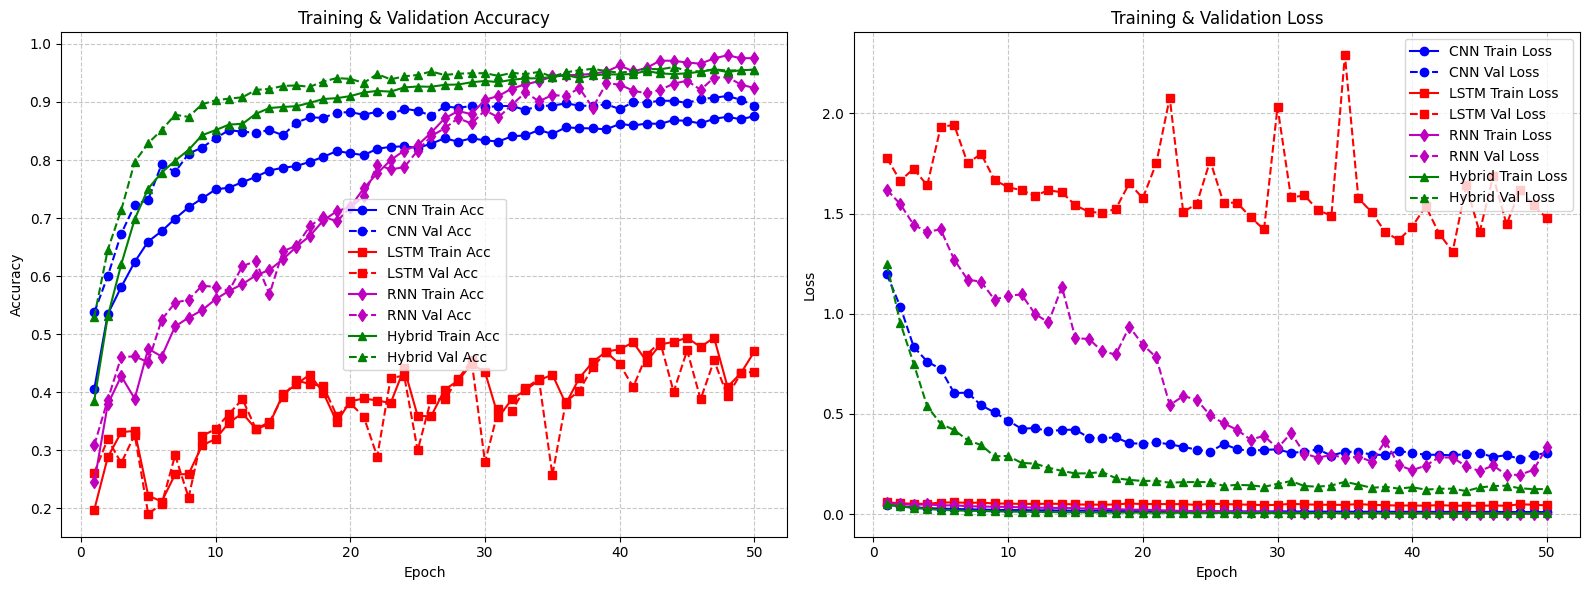

In [ ]:
plot_comparison(history_cnn, history_rnn, history_lstm, history_cnn_lstm)